In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.calibration import IsotonicRegression
from hagelslag.evaluation import DistributedROC, DistributedReliability
from scipy.stats import gamma
from datetime import datetime
from hagelslag.evaluation import ContingencyTable

In [4]:
members = ["mem{0:d}".format(m) for m in range(1, 11)]
combo_data = {}
data_path = "/Users/djgagne/track_forecasts_merged_ncar_2015_allcal_csv/"
for member in members:
    combo_data[member] = pd.read_csv(data_path + "track_forecast_data_NCAR_{0}_combined.csv".format(member), parse_dates="Date")

In [5]:
member_info = pd.read_csv("member_info_ncar_2015.csv", index_col="Ensemble_Member")
print member_info

                Microphysics
Ensemble_Member             
mem1                Thompson
mem2                Thompson
mem3                Thompson
mem4                Thompson
mem5                Thompson
mem6                Thompson
mem7                Thompson
mem8                Thompson
mem9                Thompson
mem10               Thompson


In [6]:
for member in members:
    combo_data[member]["Run_Date"] = np.array(combo_data[member]["Date"].astype("datetime64") - pd.TimedeltaIndex(combo_data[member]["Forecast_Hour"], "H"), "datetime64[D]")

In [40]:
forecast_start = np.array([datetime(2015, 5, 15), datetime(2015,6,1), 
                  datetime(2015,6,15), datetime(2015,7,1), datetime(2015,7,15)], dtype="datetime64")
forecast_end = np.array([datetime(2015, 5, 31), datetime(2015,6,14), 
                datetime(2015,6,30), datetime(2015,7,14), datetime(2015,7,30)], dtype="datetime64")
for member in members:
    combo_data[member]["Random-Forest-CV-Cal_Shape"] = np.zeros(combo_data[member].shape[0])
    combo_data[member]["Random-Forest-CV-Cal_Scale"] = np.zeros(combo_data[member].shape[0])
for f in range(forecast_start.size-1):
    for member in members:
        train_idx = (combo_data[member]["Run_Date"] >= forecast_start[f]) & \
            (combo_data[member]["Run_Date"] <= forecast_end[f]) & \
            (combo_data[member]["Hail_Size"] > 0)
        test_idx = (combo_data[member]["Run_Date"] >= forecast_start[f+1]) & \
            (combo_data[member]["Run_Date"] <= forecast_end[f+1])
        for predictand in ["Shape", "Scale"]:
            lr = LinearRegression()
            lr.fit(np.log(combo_data[member].loc[train_idx, ["Random-Forest-CV_" + predictand]]), 
                   np.log(combo_data[member].loc[train_idx, predictand]))
            print lr.coef_, lr.intercept_
            combo_data[member].loc[test_idx, "Random-Forest-CV-Cal_" + predictand] = np.exp(lr.predict(np.log(combo_data[member].loc[test_idx, ["Random-Forest-CV_" + predictand]])))
        

[ 0.29999606] 0.183400337533
[ 0.64678864] 0.586241348552
[ 0.30158048] 0.19839486131
[ 0.5669971] 0.718034236157
[ 0.19227578] 0.222305612273
[ 0.52138699] 0.835887583397
[ 0.3108851] 0.203845895743
[ 0.47772367] 0.898911235025
[ 0.33143539] 0.181674999396
[ 0.50585597] 0.892388268899
[ 0.43538781] 0.17785356408
[ 0.5983601] 0.640706676213
[ 0.39757836] 0.189650603175
[ 0.6755083] 0.53428706258
[ 0.26117553] 0.214952902982
[ 0.45900184] 0.923230709385
[ 0.12118748] 0.244374638655
[ 0.51934466] 0.824340964243
[ 0.36334398] 0.175923832289
[ 0.63034106] 0.634082079546
[ 0.42898202] 0.140137190437


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [43]:
plt.hist(np.log(combo_data[member].loc[train_idx, ["Random-Forest-CV_" + predictand]].values), bins=np.arange(0, 5, 0.2))
plt.hist(np.log(combo_data[member].loc[train_idx, [predictand]].values), bins=np.arange(0, 5, 0.2), histtype="step")


IndexingError: Unalignable boolean Series key provided

[ 0.13201075] 1.93815999089
[ 0.16316266] 1.97745321208
[ 0.1840464] 2.06847312122
[ 0.14137505] 2.08101117271
[ 0.17039276] 2.08953688574
[ 0.16688452] 1.99988746278
[ 0.14684897] 2.08548099268
[ 0.13816089] 2.00141166698
[ 0.14463523] 2.01599749317
[ 0.16144265] 2.02325550906


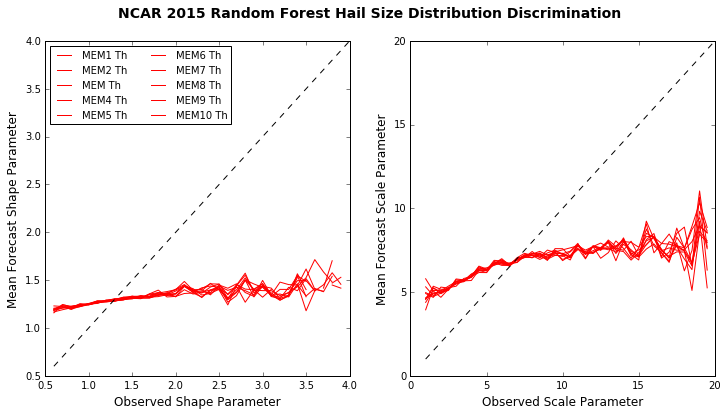

In [30]:
scale_bins = np.arange(1, 20.5, 0.5)
shape_bins = np.arange(0.6, 4.1, 0.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mp_colors = {"Thompson": "red",
         "Morrison": "green",
         "P3": "cyan",
         "MY": "blue"}
for member in members:
    matched_data = combo_data[member].loc[(combo_data[member]["Hail_Size"] > 0) & (combo_data[member]["Run_Date"] > np.datetime64("2015-05-14"))]
    obs_mean_scale = np.zeros(scale_bins.size - 1)
    obs_mean_shape = np.zeros(shape_bins.size - 1)
    obs_count_shape = np.zeros(shape_bins.size - 1)
    obs_count_scale = np.zeros(scale_bins.size - 1)

    for b, sbin in enumerate(scale_bins[:-1]):
        obs_mean_scale[b] = matched_data.loc[(matched_data["Scale"] >= sbin) & 
                                             (matched_data["Scale"] < scale_bins[b+1]), "Random-Forest-CV_Scale"].mean()
        obs_count_scale[b] = np.count_nonzero((matched_data["Scale"] >= sbin) & (matched_data["Scale"] < scale_bins[b+1]))
    for b, sbin in enumerate(shape_bins[:-1]):
        obs_mean_shape[b] = matched_data.loc[(matched_data["Shape"] >= sbin) & 
                                             (matched_data["Shape"] < shape_bins[b+1]), "Random-Forest-CV_Shape"].mean()
    lr = LinearRegression()
    lr.fit(scale_bins[:-1].reshape(-1, 1), obs_mean_scale)
    print lr.coef_, np.sum(np.abs(scale_bins[:-1] - obs_mean_scale)  * obs_count_scale / obs_count_scale.sum())
    ax1.plot(shape_bins[:-1], obs_mean_shape, label=member.strip("wrf-s3").strip("_arw").upper() + " " +
             member_info.loc[member, "Microphysics"][:2], color=mp_colors[member_info.loc[member, "Microphysics"]])
    ax2.plot(scale_bins[:-1], obs_mean_scale, label=member.strip("wrf-s3").strip("_arw").upper(),
            color=mp_colors[member_info.loc[member, "Microphysics"]])
ax1.legend(loc=0, fontsize=10, ncol=2)
ax1.plot(shape_bins, shape_bins, 'k--')
ax2.plot(scale_bins, scale_bins, 'k--')
ax1.set_ylabel("Mean Forecast Shape Parameter", fontsize=12)
ax1.set_xlabel("Observed Shape Parameter", fontsize=12)
ax2.set_ylabel("Mean Forecast Scale Parameter", fontsize=12)
ax2.set_xlabel("Observed Scale Parameter", fontsize=12)
fig.suptitle("NCAR 2015 Random Forest Hail Size Distribution Discrimination", fontsize=14, fontweight="bold")
plt.savefig("ncar_2015_random_forest_obs_rel.pdf", dpi=300, bbox_inches="tight")
plt.savefig("ncar_2015_random_forest_obs_rel.png", dpi=300, bbox_inches="tight")

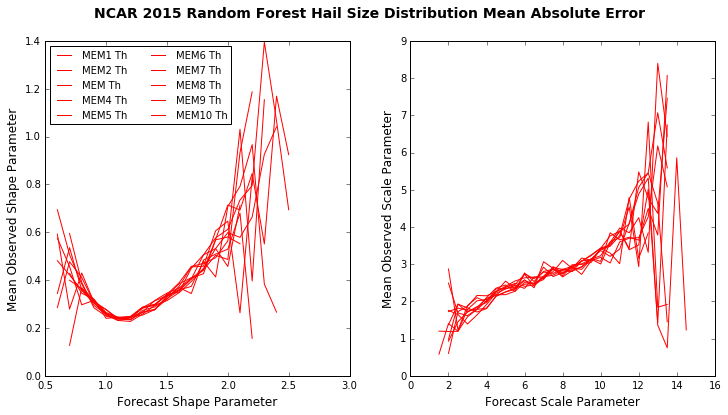

In [24]:
scale_bins = np.arange(1, 20.5, 0.5)
shape_bins = np.arange(0.6, 4.1, 0.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mp_colors = {"Thompson": "red",
         "Morrison": "green",
         "P3": "cyan",
         "MY": "blue"}
for member in members:
    matched_data = combo_data[member].loc[(combo_data[member]["Hail_Size"] > 0) & (combo_data[member]["Run_Date"] > np.datetime64("2015-05-14"))]
    obs_mean_scale = np.zeros(scale_bins.size - 1)
    obs_mean_shape = np.zeros(shape_bins.size - 1)
    for b, sbin in enumerate(scale_bins[:-1]):
        scale_idx = (matched_data["Random-Forest-CV_Scale"] >= sbin) &\
                    (matched_data["Random-Forest-CV_Scale"] < scale_bins[b+1])
        obs_mean_scale[b] = np.mean(np.abs(matched_data.loc[scale_idx, "Random-Forest-CV_Scale"] - matched_data.loc[scale_idx, "Scale"]))
    for b, sbin in enumerate(shape_bins[:-1]):
        shape_idx = (matched_data["Random-Forest-CV_Shape"] >= sbin) &\
                    (matched_data["Random-Forest-CV_Shape"] < shape_bins[b+1])
        obs_mean_shape[b] = np.mean(np.abs(matched_data.loc[shape_idx, "Random-Forest-CV_Shape"]- matched_data.loc[shape_idx, "Shape"]))
    ax1.plot(shape_bins[:-1], obs_mean_shape, label=member.strip("wrf-s3").strip("_arw").upper() + " " +
             member_info.loc[member, "Microphysics"][:2], color=mp_colors[member_info.loc[member, "Microphysics"]])
    ax2.plot(scale_bins[:-1], obs_mean_scale, label=member.strip("wrf-s3").strip("_arw").upper(),
            color=mp_colors[member_info.loc[member, "Microphysics"]])
ax1.legend(loc=0, fontsize=10, ncol=2)
#ax1.plot(shape_bins, shape_bins, 'k--')
#ax2.plot(scale_bins, scale_bins, 'k--')
ax1.set_ylabel("Mean Observed Shape Parameter", fontsize=12)
ax1.set_xlabel("Forecast Shape Parameter", fontsize=12)
ax2.set_ylabel("Mean Observed Scale Parameter", fontsize=12)
ax2.set_xlabel("Forecast Scale Parameter", fontsize=12)
fig.suptitle("NCAR 2015 Random Forest Hail Size Distribution Mean Absolute Error", fontsize=14, fontweight="bold")
plt.savefig("ncar_2015_random_forest_mae.pdf", dpi=300, bbox_inches="tight")
plt.savefig("ncar_2015_random_forest_mae.png", dpi=300, bbox_inches="tight")

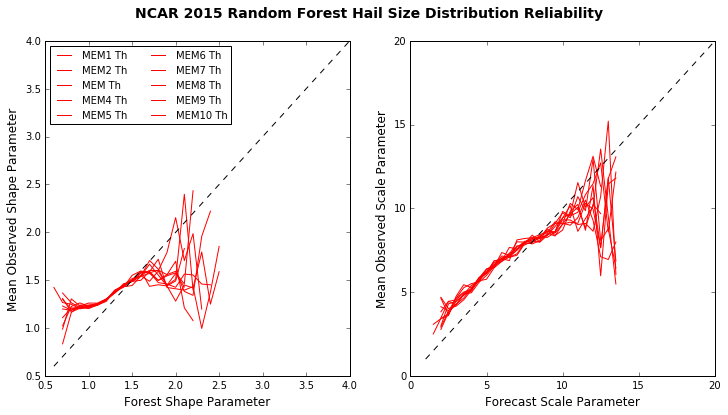

In [7]:
scale_bins = np.arange(1, 20.5, 0.5)
shape_bins = np.arange(0.6, 4.1, 0.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mp_colors = {"Thompson": "red",
         "Morrison": "green",
         "P3": "cyan",
         "MY": "blue"}
for member in members:
    matched_data = combo_data[member].loc[(combo_data[member]["Hail_Size"] > 0) & (combo_data[member]["Run_Date"] > np.datetime64("2015-05-31"))]
    obs_mean_scale = np.zeros(scale_bins.size - 1)
    obs_mean_shape = np.zeros(shape_bins.size - 1)
    for b, sbin in enumerate(scale_bins[:-1]):
        obs_mean_scale[b] = matched_data.loc[(matched_data["Random-Forest-CV_Scale"] >= sbin) & 
                                             (matched_data["Random-Forest-CV_Scale"] < scale_bins[b+1]), "Scale"].mean()
    for b, sbin in enumerate(shape_bins[:-1]):
        obs_mean_shape[b] = matched_data.loc[(matched_data["Random-Forest-CV_Shape"] >= sbin) & 
                                             (matched_data["Random-Forest-CV_Shape"] < shape_bins[b+1]), "Shape"].mean()
    ax1.plot(shape_bins[:-1], obs_mean_shape, label=member.strip("wrf-s3").strip("_arw").upper() + " " +
             member_info.loc[member, "Microphysics"][:2], color=mp_colors[member_info.loc[member, "Microphysics"]])
    ax2.plot(scale_bins[:-1], obs_mean_scale, label=member.strip("wrf-s3").strip("_arw").upper(),
            color=mp_colors[member_info.loc[member, "Microphysics"]])
ax1.legend(loc=0, fontsize=10, ncol=2)
ax1.plot(shape_bins, shape_bins, 'k--')
ax2.plot(scale_bins, scale_bins, 'k--')
ax1.set_ylabel("Mean Observed Shape Parameter", fontsize=12)
ax1.set_xlabel("Forest Shape Parameter", fontsize=12)
ax2.set_ylabel("Mean Observed Scale Parameter", fontsize=12)
ax2.set_xlabel("Forecast Scale Parameter", fontsize=12)
fig.suptitle("NCAR 2015 Random Forest Hail Size Distribution Reliability", fontsize=14, fontweight="bold")
plt.savefig("ncar_2015_random_forest_fore_rel.pdf", dpi=300, bbox_inches="tight")
plt.savefig("ncar_2015_random_forest_fore_rel.png", dpi=300, bbox_inches="tight")

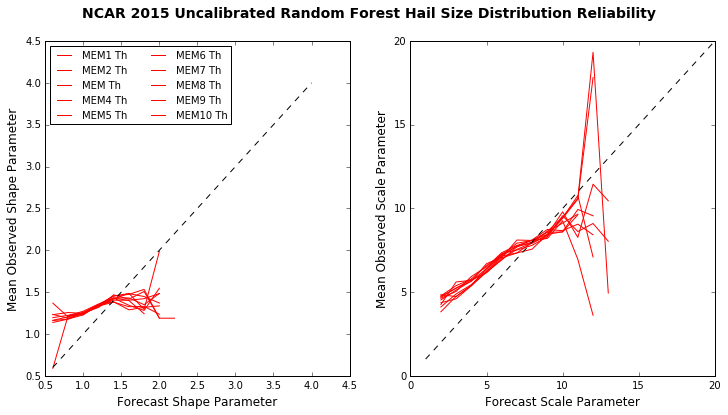

In [55]:
scale_bins = np.arange(1, 20.5, 1)
shape_bins = np.arange(0.6, 4.1, 0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mp_colors = {"Thompson": "red",
         "Morrison": "green",
         "P3": "cyan",
         "MY": "blue"}
for member in members:
    matched_data = combo_data[member].loc[(combo_data[member]["Hail_Size"] > 0) & (combo_data[member]["Run_Date"] > np.datetime64("2015-05-14"))]
    obs_mean_scale = np.zeros(scale_bins.size - 1)
    obs_mean_shape = np.zeros(shape_bins.size - 1)
    for b, sbin in enumerate(scale_bins[:-1]):
        obs_mean_scale[b] = matched_data.loc[(matched_data["Random-Forest-CV_Scale"] >= sbin) & 
                                             (matched_data["Random-Forest-CV_Scale"] < scale_bins[b+1]), "Scale"].mean()
    for b, sbin in enumerate(shape_bins[:-1]):
        obs_mean_shape[b] = matched_data.loc[(matched_data["Random-Forest-CV_Shape"] >= sbin) & 
                                             (matched_data["Random-Forest-CV_Shape"] < shape_bins[b+1]), "Shape"].mean()
    ax1.plot(shape_bins[:-1], obs_mean_shape, label=member.strip("wrf-s3").strip("_arw").upper() + " " +
             member_info.loc[member, "Microphysics"][:2], color=mp_colors[member_info.loc[member, "Microphysics"]])
    ax2.plot(scale_bins[:-1], obs_mean_scale, label=member.strip("wrf-s3").strip("_arw").upper(),
            color=mp_colors[member_info.loc[member, "Microphysics"]])
ax1.legend(loc=0, fontsize=10, ncol=2)
ax1.plot(shape_bins, shape_bins, 'k--')
ax2.plot(scale_bins, scale_bins, 'k--')
ax1.set_ylabel("Mean Observed Shape Parameter", fontsize=12)
ax1.set_xlabel("Forecast Shape Parameter", fontsize=12)
ax2.set_ylabel("Mean Observed Scale Parameter", fontsize=12)
ax2.set_xlabel("Forecast Scale Parameter", fontsize=12)
fig.suptitle("NCAR 2015 Uncalibrated Random Forest Hail Size Distribution Reliability", fontsize=14, fontweight="bold")
plt.savefig("ncar_2015_uncal_random_forest_fore_rel.pdf", dpi=300, bbox_inches="tight")
plt.savefig("ncar_2015_uncal_random_forest_fore_rel.png", dpi=300, bbox_inches="tight")

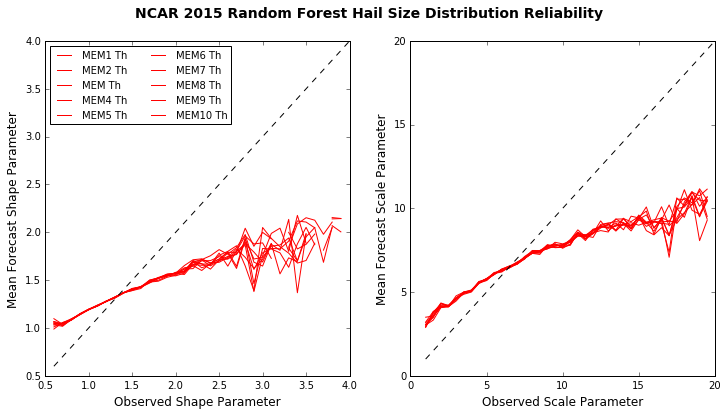

In [23]:
scale_bins = np.arange(1, 20.5, 0.5)
shape_bins = np.arange(0.6, 4.1, 0.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mp_colors = {"Thompson": "red",
         "Morrison": "green",
         "P3": "cyan",
         "MY": "blue"}
for member in members:
    matched_data = combo_data[member].loc[(combo_data[member]["Hail_Size"] > 0) & (combo_data[member]["Run_Date"] > np.datetime64("2015-05-31"))]
    obs_mean_scale = np.zeros(scale_bins.size - 1)
    obs_mean_shape = np.zeros(shape_bins.size - 1)
    for b, sbin in enumerate(scale_bins[:-1]):
        obs_mean_scale[b] = matched_data.loc[(matched_data["Scale"] >= sbin) & 
                                             (matched_data["Scale"] < scale_bins[b+1]), "Random-Forest-CV_Scale"].mean()
    for b, sbin in enumerate(shape_bins[:-1]):
        obs_mean_shape[b] = matched_data.loc[(matched_data["Shape"] >= sbin) & 
                                             (matched_data["Shape"] < shape_bins[b+1]), "Random-Forest-CV_Shape"].mean()
    ax1.plot(shape_bins[:-1], obs_mean_shape, label=member.strip("wrf-s3").strip("_arw").upper() + " " +
             member_info.loc[member, "Microphysics"][:2], color=mp_colors[member_info.loc[member, "Microphysics"]])
    ax2.plot(scale_bins[:-1], obs_mean_scale, label=member.strip("wrf-s3").strip("_arw").upper(),
            color=mp_colors[member_info.loc[member, "Microphysics"]])
ax1.legend(loc=0, fontsize=10, ncol=2)
ax1.plot(shape_bins, shape_bins, 'k--')
ax2.plot(scale_bins, scale_bins, 'k--')
ax1.set_ylabel("Mean Forecast Shape Parameter", fontsize=12)
ax1.set_xlabel("Observed Shape Parameter", fontsize=12)
ax2.set_ylabel("Mean Forecast Scale Parameter", fontsize=12)
ax2.set_xlabel("Observed Scale Parameter", fontsize=12)
fig.suptitle("NCAR 2015 Random Forest Hail Size Distribution Reliability", fontsize=14, fontweight="bold")
plt.savefig("ncar_2015_random_forest_nocal_obs_rel.pdf", dpi=300, bbox_inches="tight")
plt.savefig("ncar_2015_random_forest_nocal_obs_rel.png", dpi=300, bbox_inches="tight")

In [109]:
matched_data = combo_data["mem1"].loc[(combo_data["mem1"]["Hail_Size"] > 0) 
                                      & (combo_data[member]["Run_Date"] > np.datetime64("2015-05-14")) &
                                      (combo_data["mem1"]["Random-Forest-CV_Scale"] > 0)]

[[ 1.          0.21334556]
 [ 0.21334556  1.        ]]
[[ 1.          0.31444303]
 [ 0.31444303  1.        ]]


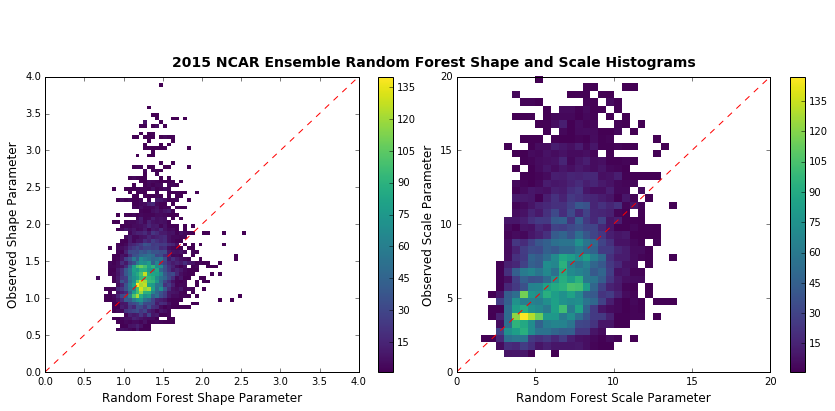

In [111]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.subplots_adjust(left=0.05, right=0.98, top=0.92, bottom=0.1, hspace=0.05, wspace=0.05)

h1 = ax1.hist2d(matched_data["Random-Forest-CV_Shape"], matched_data["Shape"], bins=np.arange(0, 5, 0.05), cmap="viridis",
          cmin=1)
print np.corrcoef(matched_data["Random-Forest-CV_Shape"], matched_data["Shape"])
ax1.plot(np.arange(0, 6), np.arange(0,6), 'r--')
plt.colorbar(h1[3], ax=ax1)
ax1.set_xlim(0, 4)
ax1.set_ylim(0, 4)
ax1.set_xlabel("Random Forest Shape Parameter", fontsize=12)
ax1.set_ylabel("Observed Shape Parameter", fontsize=12)

h2 = ax2.hist2d(matched_data["Random-Forest-CV_Scale"], matched_data["Scale"], bins=np.arange(0, 21, 0.5), 
           cmin=1,cmap="viridis")
print np.corrcoef(matched_data["Random-Forest-CV_Scale"], matched_data["Scale"])

plt.colorbar(h2[3], ax=ax2)
ax2.set_ylim(0, 20)
ax2.set_xlim(0, 20)
ax2.plot(np.arange(31), np.arange(31), 'r--')
ax2.set_xlabel("Random Forest Scale Parameter", fontsize=12)
ax2.set_ylabel("Observed Scale Parameter", fontsize=12)
fig.suptitle("2015 NCAR Ensemble Random Forest Shape and Scale Histograms", fontsize=14, fontweight="bold")
plt.savefig("ncar_2015_rf_shape_scale_hist_cal.pdf", dpi=300)

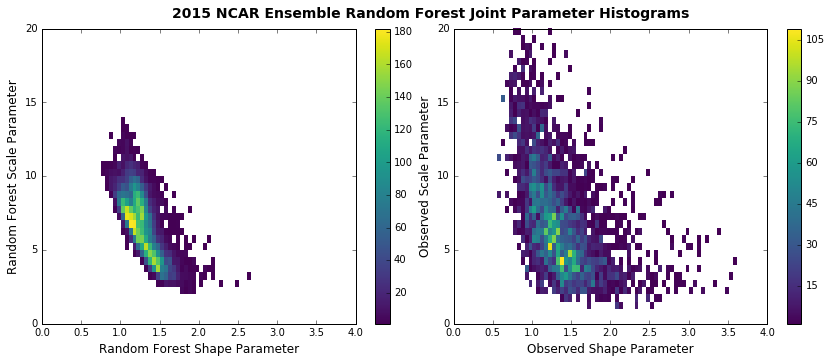

In [107]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.subplots_adjust(left=0.05, right=0.98, top=0.92, bottom=0.1, hspace=0.05, wspace=0.05)

h1 = ax1.hist2d(matched_data["Random-Forest-CV_Shape"], matched_data["Random-Forest-CV_Scale"], 
           bins=[np.arange(0,4,0.05), np.arange(0, 21, 0.5)],
           cmin=1, cmap="viridis")
plt.colorbar(h1[3], ax=ax1)

ax1.set_xlim(0, 4)
ax1.set_ylim(0, 20)
ax1.set_xlabel("Random Forest Shape Parameter",fontsize=12)
ax1.set_ylabel("Random Forest Scale Parameter", fontsize=12)
h2 = ax2.hist2d(matched_data["Shape"], matched_data["Scale"],
           bins=[np.arange(0,4,0.05), np.arange(0, 21, 0.5)],
           cmin=1, cmap="viridis")
plt.colorbar(h2[3], ax=ax2)

ax2.set_ylim(0, 20)
ax2.set_xlim(0, 4)
ax2.set_xlabel("Observed Shape Parameter", fontsize=12)
ax2.set_ylabel("Observed Scale Parameter", fontsize=12)
fig.suptitle("2015 NCAR Ensemble Random Forest Joint Parameter Histograms", fontsize=14, fontweight="bold")
plt.savefig("ncar_2015_joint_hist_cal.pdf", dpi=300)

In [75]:
samples = gamma.rvs(1.3, loc=6, scale=15, size=(100, 1000))
sorted_samples = np.sort(samples, axis=0)
sorted_samples.mean(axis=1)

array([  6.48725764,   6.84237671,   7.16109266,   7.45335928,
         7.74717354,   8.03083119,   8.30239162,   8.58727913,
         8.84701677,   9.12310349,   9.37582248,   9.62800403,
         9.89001668,  10.16718255,  10.44528319,  10.69749522,
        10.97126746,  11.22107747,  11.4835637 ,  11.73433225,
        11.99687072,  12.24754933,  12.49707317,  12.77695444,
        13.04500435,  13.31915702,  13.57366397,  13.83766575,
        14.12682841,  14.39490576,  14.66858194,  14.94450013,
        15.21958548,  15.51356797,  15.82772291,  16.12871427,
        16.43022107,  16.72721638,  17.01713811,  17.33542356,
        17.66175709,  17.98234573,  18.32518095,  18.6633107 ,
        18.98771542,  19.34166013,  19.67385745,  20.01090479,
        20.36632392,  20.7468835 ,  21.12754288,  21.48835961,
        21.89347245,  22.2584456 ,  22.64676068,  23.05831623,
        23.42750538,  23.8283949 ,  24.22331907,  24.65537513,
        25.09697191,  25.55168994,  26.00707411,  26.46

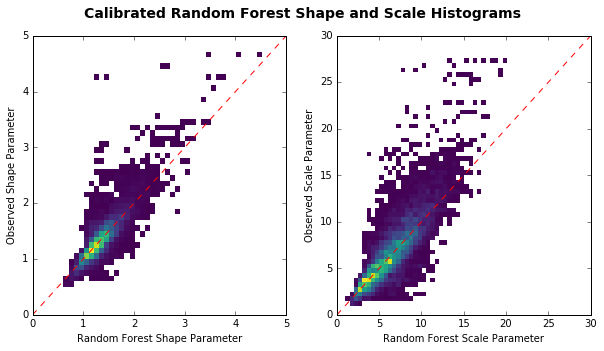

In [109]:
log_rf_shape = np.log(matched_data["Random-Forest-CV_Shape"])
log_shape = np.log(matched_data["Shape"])
log_rf_scale = np.log(matched_data["Random-Forest-CV_Scale"])
log_scale = np.log(matched_data["Scale"])
lr_shape = LinearRegression()
lr_shape.fit(log_rf_shape.reshape((log_rf_shape.shape[0], 1)), log_shape)
lr_scale = LinearRegression()
lr_scale.fit(log_rf_scale.reshape((log_rf_scale.shape[0], 1)), log_scale)
#plt.scatter(log_rf_shape, log_shape)
#plt.plot(np.arange(-1, 3), np.arange(-1, 3), 'k--')
#plt.hist2d(np.exp(lr.predict(log_rf_shape.reshape(log_rf_shape.size,1))),np.exp(log_shape), 
#           bins=np.arange(0, 30, 0.5), cmin=1, cmap="viridis")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.hist2d(np.exp(lr_shape.predict(log_rf_shape.reshape(log_rf_shape.size,1))), matched_data["Shape"], bins=np.arange(0, 5, 0.1), cmap="viridis",
          cmin=1)
ax1.plot(np.arange(0, 6), np.arange(0,6), 'r--')
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)
ax1.set_xlabel("Random Forest Shape Parameter")
ax1.set_ylabel("Observed Shape Parameter")

ax2.hist2d(np.exp(lr_scale.predict(log_rf_scale.reshape(log_rf_scale.size,1))), matched_data["Scale"], 
           bins=np.arange(0, 31, 0.5), 
           cmin=1,cmap="viridis")
ax2.set_ylim(0, 30)
ax2.set_xlim(0, 30)
ax2.plot(np.arange(31), np.arange(31), 'r--')
ax2.set_xlabel("Random Forest Scale Parameter")
ax2.set_ylabel("Observed Scale Parameter")
fig.suptitle("Calibrated Random Forest Shape and Scale Histograms", fontsize=14, fontweight="bold")
plt.savefig("rf_shape_scale_hist_cal.png", dpi=300, bbox_inches="tight")

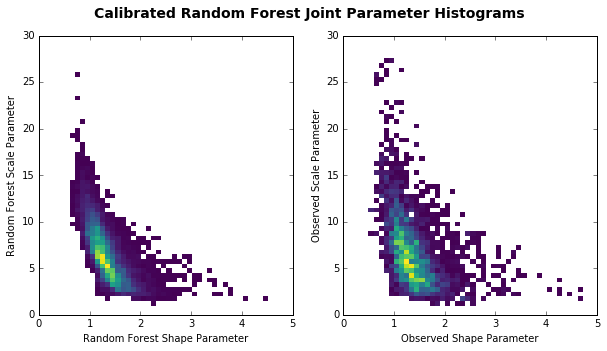

In [110]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.hist2d(np.exp(lr_shape.predict(log_rf_shape.reshape(log_rf_shape.size,1))), np.exp(lr_scale.predict(log_rf_scale.reshape(log_rf_scale.size,1))), 
           bins=[np.arange(0,5,0.1), np.arange(0, 30, 0.5)],
           cmin=1, cmap="viridis")
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 30)
ax1.set_xlabel("Random Forest Shape Parameter")
ax1.set_ylabel("Random Forest Scale Parameter")
ax2.hist2d(matched_data["Shape"], matched_data["Scale"],
           bins=[np.arange(0,5,0.1), np.arange(0, 30, 0.5)],
           cmin=1, cmap="viridis")
ax2.set_ylim(0, 30)
ax2.set_xlim(0, 5)
ax2.set_xlabel("Observed Shape Parameter")
ax2.set_ylabel("Observed Scale Parameter")
fig.suptitle("Calibrated Random Forest Joint Parameter Histograms", fontsize=14, fontweight="bold")
plt.savefig("rf_joint_hist_cal.png", dpi=300, bbox_inches="tight")

In [137]:
roc = DistributedROC(thresholds=np.arange(0, 1.01, 0.01))
roc.update(combo_data["Random-Forest_Condition"], np.where(combo_data["Hail_Size"] > 0.5, 1, 0))
rel = DistributedReliability(thresholds=np.arange(0, 1.1, 0.1))
rel.update(combo_data["Random-Forest_Condition"].values, np.where(combo_data["Hail_Size"] > 0.5, 1, 0))

         POD      POFD  Thresholds
50  0.896964  0.122617         0.5


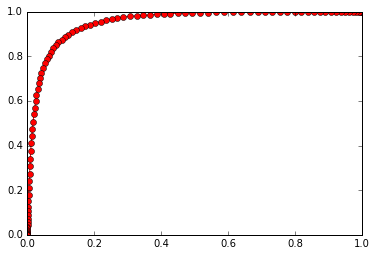

In [133]:
rc = roc.roc_curve()
plt.plot(rc["POFD"], rc["POD"], 'ro-')
print rc.loc[rc["Thresholds"] == 0.5]

In [32]:
rocs = {}
rels = {}
for member in members:
    rocs[member] = DistributedROC(thresholds=np.arange(0, 1.05, 0.05))
    rocs[member].update(combo_data[member]["Random-Forest_Condition"], 
                       np.where(combo_data[member]["Hail_Size"] > 0.5, 1, 0))
    rels[member] = DistributedReliability(thresholds=np.arange(0, 1.05, 0.05))
    rels[member].update(combo_data[member]["Random-Forest_Condition"].values, 
                       np.where(combo_data[member]["Hail_Size"] > 0.5, 1, 0))

mem1 Thompson 0.710394898432
mem2 Thompson 0.717554903316
mem3 Thompson 0.701262816021
mem4 Thompson 0.715016913656
mem5 Thompson 0.706844328346
mem6 Thompson 0.710358104542
mem7 Thompson 0.707900239678
mem8 Thompson 0.711870067199
mem9 Thompson 0.700484982689
mem10 Thompson 0.703268866478


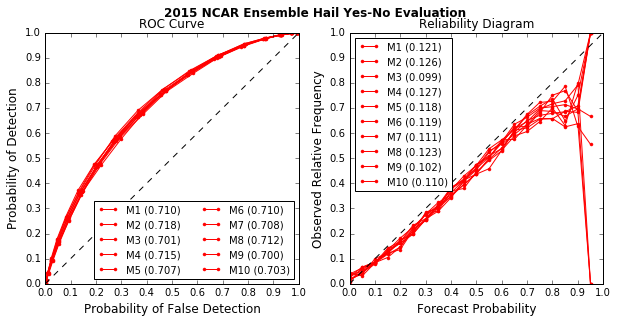

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4.5))
tick_vals = np.arange(0, 1.1, 0.1)
for member in members:
    rc = rocs[member].roc_curve()
    ax1.plot(rc["POFD"], rc["POD"], color=mp_colors[member_info.loc[member, "Microphysics"]],
            label=member[2:].upper() + " ({0:0.3f})".format(rocs[member].auc()), marker='.')
    print member, member_info.loc[member, "Microphysics"], rocs[member].auc()
    relc = rels[member].reliability_curve()
    ax2.plot(relc["Bin_Start"], relc["Positive_Relative_Freq"], color=mp_colors[member_info.loc[member, "Microphysics"]],
            label=member[2:].upper() + " ({0:0.3f})".format(rels[member].brier_skill_score()), marker='.')
ax1.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')
ax2.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')
ax1.set_xlabel("Probability of False Detection", fontsize=12)
ax1.set_ylabel("Probability of Detection", fontsize=12)
ax1.set_title("ROC Curve")
ax2.set_xlabel("Forecast Probability", fontsize=12)
ax2.set_ylabel("Observed Relative Frequency", fontsize=12)
ax2.set_title("Reliability Diagram")
ax1.set_xticks(tick_vals)
ax1.set_yticks(tick_vals)
ax2.set_xticks(tick_vals)
ax2.set_yticks(tick_vals)
fig.suptitle("2015 NCAR Ensemble Hail Yes-No Evaluation", fontsize=12, fontweight="bold")
ax1.legend(loc=0, fontsize=10, ncol=2)
ax2.legend(loc=0, fontsize=10, ncol=1)
plt.savefig("ncar_2015_hail_roc_rel.png", dpi=300, bbox_inches="tight")
plt.savefig("ncar_2015_hail_roc_rel.pdf", dpi=300, bbox_inches="tight")

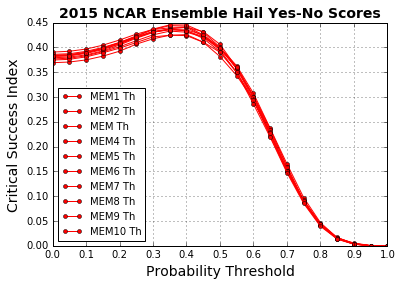

In [40]:
plt.figure(figsize=(6, 4))
hss_members = pd.DataFrame(index=rocs.values()[0].thresholds, columns=members, dtype=float)
for member in members:
    roc = rocs[member]
    hss_members.loc[:, member] = [x.csi() for x in roc.get_contingency_tables()]
    plt.plot(hss_members.index, hss_members[member], marker='o', color=mp_colors[member_info.loc[member, "Microphysics"]],
             ms=4, 
             label=member.strip("wrf-s3").strip("_arw").upper() + " " + member_info.loc[member, "Microphysics"][:2])
plt.xlabel("Probability Threshold", fontsize=14)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Critical Success Index", fontsize=14)
plt.legend(loc=0, fontsize=10)
plt.grid()
plt.title("2015 NCAR Ensemble Hail Yes-No Scores", fontsize=14, fontweight="bold")
plt.savefig("ncar_2015_csi_curves.pdf", bbox_inches="tight")

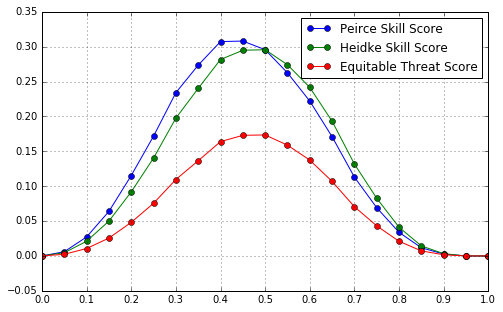

In [125]:
ct_scores = pd.DataFrame([[x.pss(), x.hss(), x.ets()] for x in roc.get_contingency_tables()],
                     columns=["Peirce Skill Score", "Heidke Skill Score", "Equitable Threat Score"], index=roc.thresholds)
ct_scores.plot(marker='o', figsize=(8, 5), xticks=np.arange(0, 1.1, 0.1), grid=True)

In [83]:
for col in matched_data.columns:
    print col

Step_ID
Track_ID
Date
Forecast_Hour
Valid_Hour_UTC
Duration
Centroid_Lon
Centroid_Lat
Storm_Motion_U
Storm_Motion_V
UP_HELI_MAX_mean
UP_HELI_MAX_max
UP_HELI_MAX_min
UP_HELI_MAX_std
UP_HELI_MAX_skew
UP_HELI_MAX_percentile_10
UP_HELI_MAX_percentile_50
UP_HELI_MAX_percentile_90
GRPL_MAX_mean
GRPL_MAX_max
GRPL_MAX_min
GRPL_MAX_std
GRPL_MAX_skew
GRPL_MAX_percentile_10
GRPL_MAX_percentile_50
GRPL_MAX_percentile_90
W_UP_MAX_mean
W_UP_MAX_max
W_UP_MAX_min
W_UP_MAX_std
W_UP_MAX_skew
W_UP_MAX_percentile_10
W_UP_MAX_percentile_50
W_UP_MAX_percentile_90
W_DN_MAX_mean
W_DN_MAX_max
W_DN_MAX_min
W_DN_MAX_std
W_DN_MAX_skew
W_DN_MAX_percentile_10
W_DN_MAX_percentile_50
W_DN_MAX_percentile_90
HAIL_MAX2D_mean
HAIL_MAX2D_max
HAIL_MAX2D_min
HAIL_MAX2D_std
HAIL_MAX2D_skew
HAIL_MAX2D_percentile_10
HAIL_MAX2D_percentile_50
HAIL_MAX2D_percentile_90
HAIL_MAXK1_mean
HAIL_MAXK1_max
HAIL_MAXK1_min
HAIL_MAXK1_std
HAIL_MAXK1_skew
HAIL_MAXK1_percentile_10
HAIL_MAXK1_percentile_50
HAIL_MAXK1_percentile_90
LTG3_MAX_mea

In [37]:
matched_data

,Step_ID,Track_ID,Date,Forecast_Hour,Valid_Hour_UTC,Duration,Centroid_Lon,Centroid_Lat,Storm_Motion_U,Storm_Motion_V,...,Random-Forest_Condition,Random-Forest_Shape,Random-Forest_Location,Random-Forest_Scale,Random-Forest-CV_Shape,Random-Forest-CV_Location,Random-Forest-CV_Scale,Run_Date,Random-Forest-CV-Cal_Shape,Random-Forest-CV-Cal_Scale
2073,mem10_GRPL_MAX_20150601-0000_17_18_003_00,mem10_GRPL_MAX_20150601-0000_17_18_003,2015-06-01 17:00:00,17.0,17.0,1.0,-83.22159,29.60884,-12000.0,15000.0,...,0.542239,1.108798,6.0,7.680519,1.068355,6.0,8.054879,2015-06-01,0.904057,9.591955
2074,mem10_GRPL_MAX_20150601-0000_17_18_003_01,mem10_GRPL_MAX_20150601-0000_17_18_003,2015-06-01 18:00:00,18.0,18.0,2.0,-83.29255,29.94958,-18000.0,30000.0,...,0.487363,1.124101,6.0,7.932735,1.090647,6.0,8.541011,2015-06-01,0.938684,10.521779
2085,mem10_GRPL_MAX_20150601-0000_18_18_007_00,mem10_GRPL_MAX_20150601-0000_18_18_007,2015-06-01 18:00:00,18.0,18.0,1.0,-82.48496,28.50237,6000.0,-15000.0,...,0.490199,1.223373,6.0,6.950088,1.281232,6.0,6.944161,2015-06-01,1.258426,7.588702
2089,mem10_GRPL_MAX_20150601-0000_18_18_011_00,mem10_GRPL_MAX_20150601-0000_18_18_011,2015-06-01 18:00:00,18.0,18.0,1.0,-76.34117,40.15469,3000.0,-9000.0,...,0.379409,1.242642,6.0,5.950833,1.217558,6.0,5.830151,2015-06-01,1.146920,5.757977
2090,mem10_GRPL_MAX_20150601-0000_18_20_012_00,mem10_GRPL_MAX_20150601-0000_18_20_012,2015-06-01 18:00:00,18.0,18.0,1.0,-74.78389,39.82668,9000.0,15000.0,...,0.215556,1.150819,6.0,7.445220,1.161292,6.0,7.343822,2015-06-01,1.052282,8.289669
2091,mem10_GRPL_MAX_20150601-0000_18_20_012_01,mem10_GRPL_MAX_20150601-0000_18_20_012,2015-06-01 19:00:00,19.0,19.0,2.0,-74.59652,39.87991,12000.0,6000.0,...,0.327639,1.225991,6.0,6.176495,1.258217,6.0,6.152979,2015-06-01,1.217585,6.269368
2092,mem10_GRPL_MAX_20150601-0000_18_20_012_02,mem10_GRPL_MAX_20150601-0000_18_20_012,2015-06-01 20:00:00,20.0,20.0,3.0,-74.40057,39.84263,18000.0,3000.0,...,0.412998,1.270993,6.0,5.852983,1.266788,6.0,6.241852,2015-06-01,1.232724,6.412936
2093,mem10_GRPL_MAX_20150601-0000_19_19_013_00,mem10_GRPL_MAX_20150601-0000_19_19_013,2015-06-01 19:00:00,19.0,19.0,1.0,-82.75189,29.38902,0.0,0.0,...,0.391286,1.074253,6.0,8.151232,1.037116,6.0,8.602250,2015-06-01,0.856519,10.641136
2099,mem10_GRPL_MAX_20150601-0000_19_19_016_00,mem10_GRPL_MAX_20150601-0000_19_19_016,2015-06-01 19:00:00,19.0,19.0,1.0,-82.26801,31.03949,-3000.0,-9000.0,...,0.503283,1.067658,6.0,8.437170,1.047616,6.0,8.531023,2015-06-01,0.872369,10.502360
2108,mem10_GRPL_MAX_20150601-0000_19_21_023_00,mem10_GRPL_MAX_20150601-0000_19_21_023,2015-06-01 19:00:00,19.0,19.0,1.0,-77.97156,38.52663,12000.0,-18000.0,...,0.414546,1.079046,6.0,8.199446,0.988724,6.0,9.809911,2015-06-01,0.785173,13.093807


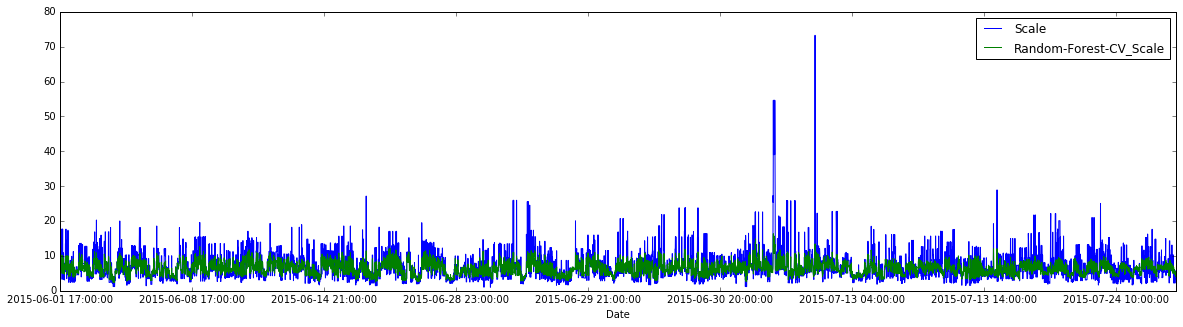

In [42]:
matched_data.plot(x="Date", y=["Scale", "Random-Forest-CV_Scale"], figsize=(20,5))

0.137695430571 0.573858993919


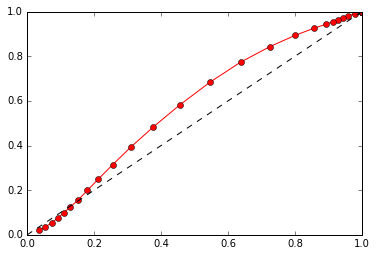

In [63]:
uh_threshs = np.arange(0, 36, 1)
pod = np.zeros(uh_threshs.shape)
pofd = np.zeros(uh_threshs.shape)
for u, uh_thresh in enumerate(uh_threshs):
    pos_events = combo_data["mem1"]["Forecast_Hour"] >= uh_thresh
    neg_events = combo_data["mem1"]["Forecast_Hour"] <= uh_thresh
    tp = np.count_nonzero(combo_data["mem1"].loc[pos_events, "Hail_Size"] > 0)
    fp = np.count_nonzero(combo_data["mem1"].loc[pos_events, "Hail_Size"] == 0)
    fn = np.count_nonzero(combo_data["mem1"].loc[neg_events, "Hail_Size"] > 0)
    tn = np.count_nonzero(combo_data["mem1"].loc[neg_events, "Hail_Size"] == 0)
    ct = ContingencyTable(tp, fp, fn, tn)
    pod[u] = ct.pod()
    pofd[u] = ct.pofd()
print np.max(pod - pofd), -np.trapz(pod, pofd)
plt.plot(pofd, pod, 'ro-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')

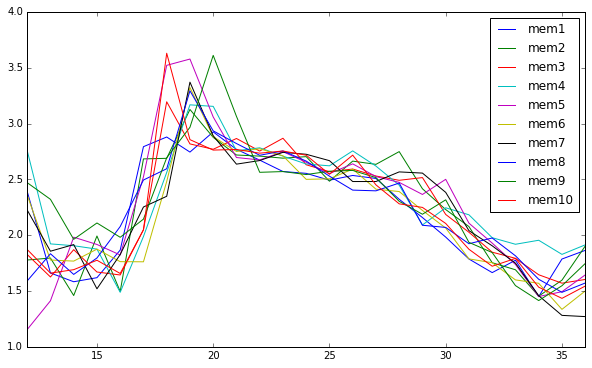

In [126]:
forecast_hours = np.arange(12, 37)
model_name = "Random-Forest-CV_Scale"
obs_name = "Scale"
hour_mae = pd.DataFrame(index=forecast_hours, columns=members, dtype=float)
for member in members:
    for f_hour in forecast_hours:
        idx = (combo_data[member].Forecast_Hour == f_hour) & (combo_data[member][obs_name] > 0)
        hour_fore = combo_data[member].loc[idx, model_name]
        hour_obs = combo_data[member].loc[idx, obs_name]
        hour_mae.loc[f_hour, member] = np.mean(np.abs(hour_fore - hour_obs))
hour_mae.plot(figsize=(10, 6))
        

In [134]:
sub_rocs = []
sub_rels = []
start_dates = pd.DatetimeIndex(["2015-05-15", "2015-06-01", "2015-06-15", "2015-07-01", "2015-07-15"])
end_dates = pd.DatetimeIndex(["2015-05-31", "2015-06-14", "2015-06-30", "2015-07-14", "2015-07-31"])
for s in range(len(start_dates)):
    tidx = (combo_data["mem1"]["Run_Date"] >= start_dates[s]) & (combo_data["mem1"]["Run_Date"] <= end_dates[s])
    sub_rocs.append(DistributedROC(thresholds=np.arange(0, 1.05, 0.05)))
    sub_rocs[-1].update(combo_data[member]["Random-Forest_Condition"][tidx].values,  
                       np.where(combo_data[member]["Hail_Size"][tidx] > 0.5, 1, 0))
    sub_rels.append(DistributedReliability(thresholds=np.arange(0, 1.05, 0.05)))
    sub_rels[-1].update(combo_data[member]["Random-Forest_Condition"][tidx].values, 
                    np.where(combo_data[member]["Hail_Size"][tidx] > 0.5, 1, 0))
    print sub_rocs[-1].auc(), sub_rels[-1].brier_skill_score()

0.696373719387 0.109325846424
0.704785053084 0.0910006141873
0.70504681094 0.123174189452
0.69682540719 0.103779309475
0.733815711717 0.085334923842


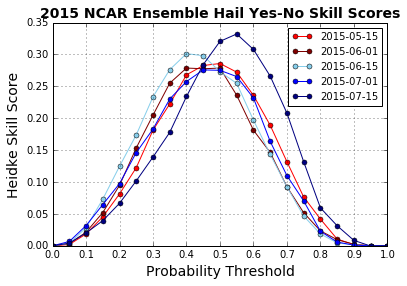

In [153]:
plt.figure(figsize=(6, 4))
sroc_colors = ["red", "maroon", "skyblue", "blue", "navy"]
for s, sub_roc in enumerate(sub_rocs):
    plt.plot(sub_roc.thresholds, 
             [sr.hss() for sr in sub_roc.get_contingency_tables()], label=start_dates[s].strftime("%Y-%m-%d"),
            marker='o', ms=5, color=sroc_colors[s])
plt.legend(loc=0, fontsize=10)
plt.grid()
plt.xlabel("Probability Threshold", fontsize=14)
plt.ylabel("Heidke Skill Score", fontsize=14)
plt.title("2015 NCAR Ensemble Hail Yes-No Skill Scores", fontsize=14, fontweight="bold")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 0.35)
plt.savefig("ncar_2015_hss_curves.pdf", bbox_inches="tight")